In [1]:
%%capture
%pip install scikit-learn matplotlib transformers pandas

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import  transforms, datasets
import pandas as pd
from tqdm import tqdm
from torch.utils.data import random_split, DataLoader, Subset, Dataset
from PIL import Image
# from torchvision.transforms import InterpolationMode
from sklearn.metrics import accuracy_score, f1_score, classification_report, recall_score, precision_score
import random
import numpy as np
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification, ViTImageProcessor
# from transformers import SwinForImageClassification, AutoImageProcessor, AutoModelForZeroShotImageClassification
import torch.nn as nn
import torch
from torchvision import models
import os


# Define variable enviroment

In [3]:
SEED = 25
random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
TEST_FOLDER_PATH = './data/test'
TRAIN_FOLDER_PATH = './data/train'

In [5]:
label_map = {
    "đông cô": "0",
    "tai mèo": "1",
    "tuyết khô": "2",
}

In [6]:
def imshow(img_tensor):
    img = img_tensor.permute(1, 2, 0) 
    img = img.numpy()
    plt.imshow(img)
    plt.axis('off')

# Transform

In [7]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

transform = transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.2),
        transforms.RandomRotation(degrees=15),
    
        transforms.ColorJitter(brightness=0.6, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAdjustSharpness(sharpness_factor=4, p=0.5),
        transforms.RandomAutocontrast(p=0.4),
        transforms.RandomEqualize(p=0.2),
    
        transforms.ToTensor(),
        transforms.GaussianBlur(kernel_size=(5,9), sigma=(0.1,5)),
        transforms.RandomErasing(
            p=0.3,
            scale=(0.02, 0.10),       
            ratio=(0.3, 3.3),         
            value='random'            
        ),
        transforms.Normalize(mean=mean, std=std),
])

test_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [8]:
class CustomTestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.image_paths = sorted([os.path.join(test_dir, fname)
                                   for fname in os.listdir(test_dir)
                                   if fname.lower().endswith(('.png', '.jpg', '.jpeg'))])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, os.path.basename(img_path) 

class SubsetWithTransform(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, label = self.subset[idx]       
        if self.transform:
            image = self.transform(image)     
        return image, label

# Define Dataset

In [9]:
base_dataset = datasets.ImageFolder(root=TRAIN_FOLDER_PATH, transform=None)
dataset_size = len(base_dataset)

# Tính toán tỷ lệ
val_ratio = 0.2
test_ratio = 0.2  # giả sử test lấy 10% từ tập huấn luyện

val_size = int(val_ratio * dataset_size)
test_size = int(test_ratio * dataset_size)
train_size = dataset_size - val_size - test_size

# Chia tập dữ liệu với seed cố định
train_subset, val_subset, test_subset = random_split(
    base_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(SEED)
)

# Apply transform sau khi chia
train_dataset = SubsetWithTransform(train_subset, transform)
val_dataset   = SubsetWithTransform(val_subset,   test_transform)
test_dataset  = SubsetWithTransform(test_subset,  test_transform)

batch_size = 64
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)
print(len(train_dataset), len(val_dataset), len(test_dataset))

class_names = base_dataset.classes
print("Classes:", class_names)
print("Original class_to_idx mapping:")
print(base_dataset.class_to_idx)


630 210 210
Classes: ['tai mèo', 'tuyết khô', 'đông cô']
Original class_to_idx mapping:
{'tai mèo': 0, 'tuyết khô': 1, 'đông cô': 2}


In [10]:
# base_dataset = datasets.ImageFolder(root=TRAIN_FOLDER_PATH,transform=None)
# dataset_size = len(base_dataset)

# # train/val
# val_size     = int(0.2 * dataset_size)
# train_size   = dataset_size - val_size
# train_subset, val_subset = random_split(base_dataset, [train_size, val_size],generator=torch.Generator().manual_seed(SEED))

# train_dataset = SubsetWithTransform(train_subset, transform)
# val_dataset   = SubsetWithTransform(val_subset,   test_transform)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)

# # test
# test_dir = TEST_FOLDER_PATH
# test_dataset = CustomTestDataset(test_dir, transform=test_transform)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# class_names = base_dataset.classes
# print("Classes:", class_names)
# print("Original class_to_idx mapping:")
# print(base_dataset.class_to_idx)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-20.467505..16.97819].


./data/train/đông cô/DC194.jpg


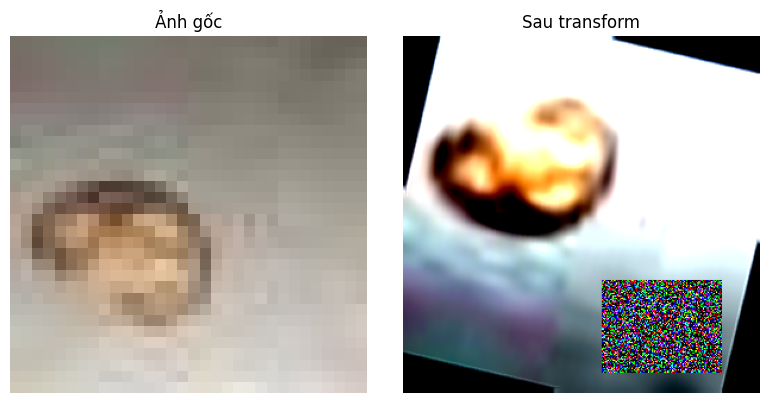

In [11]:
folder_path = TRAIN_FOLDER_PATH +"/đông cô" 
image_files = os.listdir(folder_path)
image_path = os.path.join(folder_path, random.choice(image_files))
img_original = Image.open(image_path).convert('RGB')
img_transformed = transform(img_original)
print(image_path)

def tensor_to_img(img_tensor):
    img = img_tensor.permute(1, 2, 0).numpy()
    return img

# Vẽ ảnh gốc và ảnh transform
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_original)
plt.title("Ảnh gốc")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(tensor_to_img(img_transformed))
plt.title("Sau transform")
plt.axis("off")

plt.tight_layout()
plt.show()

In [12]:
idx_to_class = {
    base_dataset.class_to_idx[orig]: label_map[orig]
    for orig in base_dataset.classes
}
print("Final class labels (used for submission):")
print(idx_to_class)

Final class labels (used for submission):
{0: '1', 1: '2', 2: '0'}


# Train/Eval Function

In [13]:
def evaluate_model(model, dataloader, idx_to_class, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Chuyển label và pred sang dạng label chuẩn hóa (string)
            pred_labels = [idx_to_class[p.item()] for p in preds]
            true_labels = [idx_to_class[l.item()] for l in labels]

            all_preds.extend(pred_labels)
            all_labels.extend(true_labels)

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds,  average='weighted')
    print(f'Accuracy: {acc:.4f} | F1 Score: {f1:.4f} | Recall Score: {recall:.4f} | Precision Score: {precision:.4f}')
    # print(classification_report(all_labels, all_preds))
    return acc

In [14]:
def train(model, dataloader,val_loader, epochs=30):
    model.to(device)
    best_val_loss = float('inf')  # Initialize with a very large value
    patience = 10  # Number of epochs to wait before early stopping
    patience_counter = 0

    # Lists to store training and validation losses
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()

            running_loss += loss.item()
        
        # Record training loss for this epoch
        epoch_train_loss = running_loss / len(dataloader)
        train_losses.append(epoch_train_loss) 
        print(f"Epoch {epoch+1}, Loss: {epoch_train_loss:.4f}", end=', ')

        # Validation phase
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                # Chuyển label và pred sang dạng label chuẩn hóa (string)
                pred_labels = [idx_to_class[p.item()] for p in preds]
                true_labels = [idx_to_class[l.item()] for l in labels]
            
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                all_preds.extend(pred_labels)
                all_labels.extend(true_labels)
        
        # Record validation loss for this epoch
        epoch_val_loss = val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        
        acc = accuracy_score(all_labels, all_preds)
        print(f'Loss Valid: {epoch_val_loss:.4f}, Accuracy Valid: {acc:.4f}')
        evaluate_model(model, test_loader, idx_to_class, device)
        
        # Early stopping check
        if epoch_val_loss < best_val_loss: 
            best_val_loss = epoch_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break  
    scheduler.step()
        
    # Plotting Training and Validation Curves after training loop
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Model

In [15]:
class EfficientNetClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(EfficientNetClassifier, self).__init__()
        self.model = models.efficientnet_b3(pretrained=True)

        # Bỏ phần classifier gốc
        self.features = self.model.features

        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1)) 
        in_features = self.model.classifier[1].in_features
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.features(x)                         
        x = self.adaptive_pool(x)                    
        x = torch.flatten(x, 1)                      
        x = self.dropout(x)                          
        x = self.fc(x)                               
        return x

model = EfficientNetClassifier(num_classes=3)

/venv/main/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/venv/main/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
# import torch
# import torch.nn as nn
# from torchvision import models

# class ResNet50Classifier(nn.Module):
#     def __init__(self, num_classes=3):
#         super(ResNet50Classifier, self).__init__()
#         self.model = models.resnet50(pretrained=True)

#         # Thay thế fully connected layer cuối cùng
#         in_features = self.model.fc.in_features
#         self.model.fc = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(in_features, num_classes)
#         )

#     def forward(self, x):
#         return self.model(x)

# # Khởi tạo model
# model = ResNet50Classifier(num_classes=3)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5, weight_decay=0.001) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.01)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Số lượng tham số được huấn luyện: {trainable_params}")

device

Số lượng tham số được huấn luyện: 12237843


device(type='cuda')

100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


Epoch 1, Loss: 1.1043, Loss Valid: 1.0826, Accuracy Valid: 0.4048
Accuracy: 0.4381 | F1 Score: 0.4380 | Recall Score: 0.4381 | Precision Score: 0.4380


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Epoch 2, Loss: 1.0635, Loss Valid: 1.0431, Accuracy Valid: 0.5571
Accuracy: 0.5952 | F1 Score: 0.5892 | Recall Score: 0.5952 | Precision Score: 0.6248


100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


Epoch 3, Loss: 1.0495, Loss Valid: 1.0067, Accuracy Valid: 0.6667
Accuracy: 0.6952 | F1 Score: 0.6906 | Recall Score: 0.6952 | Precision Score: 0.7297


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Epoch 4, Loss: 1.0165, Loss Valid: 0.9742, Accuracy Valid: 0.7333
Accuracy: 0.7238 | F1 Score: 0.7219 | Recall Score: 0.7238 | Precision Score: 0.7583


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Epoch 5, Loss: 0.9903, Loss Valid: 0.9417, Accuracy Valid: 0.7667
Accuracy: 0.7619 | F1 Score: 0.7589 | Recall Score: 0.7619 | Precision Score: 0.7925


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Epoch 6, Loss: 0.9546, Loss Valid: 0.9113, Accuracy Valid: 0.8000
Accuracy: 0.7905 | F1 Score: 0.7874 | Recall Score: 0.7905 | Precision Score: 0.8233


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Epoch 7, Loss: 0.9281, Loss Valid: 0.8714, Accuracy Valid: 0.8286
Accuracy: 0.7952 | F1 Score: 0.7923 | Recall Score: 0.7952 | Precision Score: 0.8299


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Epoch 8, Loss: 0.8910, Loss Valid: 0.8302, Accuracy Valid: 0.8524
Accuracy: 0.8333 | F1 Score: 0.8296 | Recall Score: 0.8333 | Precision Score: 0.8626


100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


Epoch 9, Loss: 0.8501, Loss Valid: 0.7882, Accuracy Valid: 0.8571
Accuracy: 0.8286 | F1 Score: 0.8236 | Recall Score: 0.8286 | Precision Score: 0.8626


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Epoch 10, Loss: 0.7979, Loss Valid: 0.7392, Accuracy Valid: 0.8524
Accuracy: 0.8476 | F1 Score: 0.8433 | Recall Score: 0.8476 | Precision Score: 0.8737


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Epoch 11, Loss: 0.7501, Loss Valid: 0.6835, Accuracy Valid: 0.8762
Accuracy: 0.8714 | F1 Score: 0.8673 | Recall Score: 0.8714 | Precision Score: 0.8916


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Epoch 12, Loss: 0.6990, Loss Valid: 0.6250, Accuracy Valid: 0.8857
Accuracy: 0.8810 | F1 Score: 0.8772 | Recall Score: 0.8810 | Precision Score: 0.9018


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Epoch 13, Loss: 0.6449, Loss Valid: 0.5647, Accuracy Valid: 0.8857
Accuracy: 0.8857 | F1 Score: 0.8823 | Recall Score: 0.8857 | Precision Score: 0.9048


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Epoch 14, Loss: 0.5976, Loss Valid: 0.5123, Accuracy Valid: 0.8905
Accuracy: 0.8952 | F1 Score: 0.8924 | Recall Score: 0.8952 | Precision Score: 0.9110


100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


Epoch 15, Loss: 0.5495, Loss Valid: 0.4564, Accuracy Valid: 0.9000
Accuracy: 0.8952 | F1 Score: 0.8924 | Recall Score: 0.8952 | Precision Score: 0.9110


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Epoch 16, Loss: 0.5008, Loss Valid: 0.4097, Accuracy Valid: 0.8952
Accuracy: 0.9000 | F1 Score: 0.8967 | Recall Score: 0.9000 | Precision Score: 0.9147


100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


Epoch 17, Loss: 0.4386, Loss Valid: 0.3625, Accuracy Valid: 0.9143
Accuracy: 0.9143 | F1 Score: 0.9122 | Recall Score: 0.9143 | Precision Score: 0.9258


100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


Epoch 18, Loss: 0.4131, Loss Valid: 0.3199, Accuracy Valid: 0.9286
Accuracy: 0.9143 | F1 Score: 0.9122 | Recall Score: 0.9143 | Precision Score: 0.9258


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Epoch 19, Loss: 0.3583, Loss Valid: 0.2764, Accuracy Valid: 0.9286
Accuracy: 0.9381 | F1 Score: 0.9376 | Recall Score: 0.9381 | Precision Score: 0.9461


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Epoch 20, Loss: 0.3337, Loss Valid: 0.2459, Accuracy Valid: 0.9381
Accuracy: 0.9429 | F1 Score: 0.9424 | Recall Score: 0.9429 | Precision Score: 0.9496


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Epoch 21, Loss: 0.2846, Loss Valid: 0.2148, Accuracy Valid: 0.9476
Accuracy: 0.9524 | F1 Score: 0.9520 | Recall Score: 0.9524 | Precision Score: 0.9569


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Epoch 22, Loss: 0.2679, Loss Valid: 0.1884, Accuracy Valid: 0.9524
Accuracy: 0.9524 | F1 Score: 0.9520 | Recall Score: 0.9524 | Precision Score: 0.9569


100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


Epoch 23, Loss: 0.2375, Loss Valid: 0.1654, Accuracy Valid: 0.9571
Accuracy: 0.9571 | F1 Score: 0.9571 | Recall Score: 0.9571 | Precision Score: 0.9615


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Epoch 24, Loss: 0.2121, Loss Valid: 0.1463, Accuracy Valid: 0.9571
Accuracy: 0.9571 | F1 Score: 0.9571 | Recall Score: 0.9571 | Precision Score: 0.9615


100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


Epoch 25, Loss: 0.1952, Loss Valid: 0.1321, Accuracy Valid: 0.9667
Accuracy: 0.9571 | F1 Score: 0.9571 | Recall Score: 0.9571 | Precision Score: 0.9615


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Epoch 26, Loss: 0.1879, Loss Valid: 0.1207, Accuracy Valid: 0.9714
Accuracy: 0.9619 | F1 Score: 0.9618 | Recall Score: 0.9619 | Precision Score: 0.9653


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Epoch 27, Loss: 0.1694, Loss Valid: 0.1109, Accuracy Valid: 0.9714
Accuracy: 0.9619 | F1 Score: 0.9618 | Recall Score: 0.9619 | Precision Score: 0.9653


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Epoch 28, Loss: 0.1450, Loss Valid: 0.1090, Accuracy Valid: 0.9714
Accuracy: 0.9667 | F1 Score: 0.9666 | Recall Score: 0.9667 | Precision Score: 0.9692


100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


Epoch 29, Loss: 0.1582, Loss Valid: 0.1014, Accuracy Valid: 0.9714
Accuracy: 0.9667 | F1 Score: 0.9666 | Recall Score: 0.9667 | Precision Score: 0.9692


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Epoch 30, Loss: 0.1312, Loss Valid: 0.0958, Accuracy Valid: 0.9714
Accuracy: 0.9667 | F1 Score: 0.9666 | Recall Score: 0.9667 | Precision Score: 0.9692


100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


Epoch 31, Loss: 0.1336, Loss Valid: 0.0876, Accuracy Valid: 0.9714
Accuracy: 0.9619 | F1 Score: 0.9617 | Recall Score: 0.9619 | Precision Score: 0.9646


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Epoch 32, Loss: 0.1290, Loss Valid: 0.0776, Accuracy Valid: 0.9714
Accuracy: 0.9762 | F1 Score: 0.9761 | Recall Score: 0.9762 | Precision Score: 0.9774


100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


Epoch 33, Loss: 0.1063, Loss Valid: 0.0755, Accuracy Valid: 0.9714
Accuracy: 0.9714 | F1 Score: 0.9714 | Recall Score: 0.9714 | Precision Score: 0.9732


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Epoch 34, Loss: 0.1187, Loss Valid: 0.0710, Accuracy Valid: 0.9762
Accuracy: 0.9762 | F1 Score: 0.9761 | Recall Score: 0.9762 | Precision Score: 0.9774


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Epoch 35, Loss: 0.0949, Loss Valid: 0.0656, Accuracy Valid: 0.9762
Accuracy: 0.9810 | F1 Score: 0.9809 | Recall Score: 0.9810 | Precision Score: 0.9817


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Epoch 36, Loss: 0.0904, Loss Valid: 0.0643, Accuracy Valid: 0.9762
Accuracy: 0.9762 | F1 Score: 0.9761 | Recall Score: 0.9762 | Precision Score: 0.9774


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Epoch 37, Loss: 0.0963, Loss Valid: 0.0595, Accuracy Valid: 0.9762
Accuracy: 0.9810 | F1 Score: 0.9809 | Recall Score: 0.9810 | Precision Score: 0.9817


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Epoch 38, Loss: 0.0758, Loss Valid: 0.0587, Accuracy Valid: 0.9762
Accuracy: 0.9810 | F1 Score: 0.9809 | Recall Score: 0.9810 | Precision Score: 0.9817


100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


Epoch 39, Loss: 0.0824, Loss Valid: 0.0530, Accuracy Valid: 0.9857
Accuracy: 0.9810 | F1 Score: 0.9809 | Recall Score: 0.9810 | Precision Score: 0.9817


100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


Epoch 40, Loss: 0.0797, Loss Valid: 0.0505, Accuracy Valid: 0.9857
Accuracy: 0.9810 | F1 Score: 0.9809 | Recall Score: 0.9810 | Precision Score: 0.9817


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Epoch 41, Loss: 0.0718, Loss Valid: 0.0493, Accuracy Valid: 0.9857
Accuracy: 0.9810 | F1 Score: 0.9809 | Recall Score: 0.9810 | Precision Score: 0.9817


100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


Epoch 42, Loss: 0.0765, Loss Valid: 0.0492, Accuracy Valid: 0.9810
Accuracy: 0.9810 | F1 Score: 0.9809 | Recall Score: 0.9810 | Precision Score: 0.9817


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Epoch 43, Loss: 0.0610, Loss Valid: 0.0465, Accuracy Valid: 0.9857
Accuracy: 0.9810 | F1 Score: 0.9809 | Recall Score: 0.9810 | Precision Score: 0.9817


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Epoch 44, Loss: 0.0838, Loss Valid: 0.0454, Accuracy Valid: 0.9857
Accuracy: 0.9810 | F1 Score: 0.9809 | Recall Score: 0.9810 | Precision Score: 0.9817


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Epoch 45, Loss: 0.0744, Loss Valid: 0.0435, Accuracy Valid: 0.9810
Accuracy: 0.9810 | F1 Score: 0.9809 | Recall Score: 0.9810 | Precision Score: 0.9817


100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


Epoch 46, Loss: 0.0540, Loss Valid: 0.0421, Accuracy Valid: 0.9810
Accuracy: 0.9857 | F1 Score: 0.9857 | Recall Score: 0.9857 | Precision Score: 0.9861


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Epoch 47, Loss: 0.0577, Loss Valid: 0.0400, Accuracy Valid: 0.9810
Accuracy: 0.9857 | F1 Score: 0.9857 | Recall Score: 0.9857 | Precision Score: 0.9861


100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


Epoch 48, Loss: 0.0621, Loss Valid: 0.0416, Accuracy Valid: 0.9810
Accuracy: 0.9857 | F1 Score: 0.9857 | Recall Score: 0.9857 | Precision Score: 0.9861


100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


Epoch 49, Loss: 0.0681, Loss Valid: 0.0391, Accuracy Valid: 0.9810
Accuracy: 0.9857 | F1 Score: 0.9857 | Recall Score: 0.9857 | Precision Score: 0.9861


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Epoch 50, Loss: 0.0503, Loss Valid: 0.0377, Accuracy Valid: 0.9857
Accuracy: 0.9857 | F1 Score: 0.9857 | Recall Score: 0.9857 | Precision Score: 0.9861


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Epoch 51, Loss: 0.0428, Loss Valid: 0.0390, Accuracy Valid: 0.9905
Accuracy: 0.9810 | F1 Score: 0.9809 | Recall Score: 0.9810 | Precision Score: 0.9817


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Epoch 52, Loss: 0.0419, Loss Valid: 0.0376, Accuracy Valid: 0.9905
Accuracy: 0.9810 | F1 Score: 0.9809 | Recall Score: 0.9810 | Precision Score: 0.9817


100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


Epoch 53, Loss: 0.0641, Loss Valid: 0.0370, Accuracy Valid: 0.9905
Accuracy: 0.9857 | F1 Score: 0.9857 | Recall Score: 0.9857 | Precision Score: 0.9861


100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


Epoch 54, Loss: 0.0517, Loss Valid: 0.0356, Accuracy Valid: 0.9905
Accuracy: 0.9857 | F1 Score: 0.9857 | Recall Score: 0.9857 | Precision Score: 0.9861


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Epoch 55, Loss: 0.0542, Loss Valid: 0.0358, Accuracy Valid: 0.9905
Accuracy: 0.9857 | F1 Score: 0.9857 | Recall Score: 0.9857 | Precision Score: 0.9861


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Epoch 56, Loss: 0.0489, Loss Valid: 0.0337, Accuracy Valid: 0.9905
Accuracy: 0.9857 | F1 Score: 0.9857 | Recall Score: 0.9857 | Precision Score: 0.9861


100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


Epoch 57, Loss: 0.0361, Loss Valid: 0.0334, Accuracy Valid: 0.9905
Accuracy: 0.9857 | F1 Score: 0.9857 | Recall Score: 0.9857 | Precision Score: 0.9861


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Epoch 58, Loss: 0.0573, Loss Valid: 0.0328, Accuracy Valid: 0.9905
Accuracy: 0.9857 | F1 Score: 0.9857 | Recall Score: 0.9857 | Precision Score: 0.9861


100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


Epoch 59, Loss: 0.0405, Loss Valid: 0.0336, Accuracy Valid: 0.9857
Accuracy: 0.9857 | F1 Score: 0.9857 | Recall Score: 0.9857 | Precision Score: 0.9861


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Epoch 60, Loss: 0.0488, Loss Valid: 0.0326, Accuracy Valid: 0.9810
Accuracy: 0.9905 | F1 Score: 0.9905 | Recall Score: 0.9905 | Precision Score: 0.9906


100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


Epoch 61, Loss: 0.0323, Loss Valid: 0.0339, Accuracy Valid: 0.9857
Accuracy: 0.9857 | F1 Score: 0.9857 | Recall Score: 0.9857 | Precision Score: 0.9861


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Epoch 62, Loss: 0.0402, Loss Valid: 0.0333, Accuracy Valid: 0.9810
Accuracy: 0.9952 | F1 Score: 0.9952 | Recall Score: 0.9952 | Precision Score: 0.9953


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Epoch 63, Loss: 0.0325, Loss Valid: 0.0336, Accuracy Valid: 0.9810
Accuracy: 0.9952 | F1 Score: 0.9952 | Recall Score: 0.9952 | Precision Score: 0.9953


100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


Epoch 64, Loss: 0.0300, Loss Valid: 0.0348, Accuracy Valid: 0.9857
Accuracy: 0.9857 | F1 Score: 0.9857 | Recall Score: 0.9857 | Precision Score: 0.9861


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Epoch 65, Loss: 0.0348, Loss Valid: 0.0366, Accuracy Valid: 0.9857
Accuracy: 0.9857 | F1 Score: 0.9857 | Recall Score: 0.9857 | Precision Score: 0.9861


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Epoch 66, Loss: 0.0324, Loss Valid: 0.0342, Accuracy Valid: 0.9857
Accuracy: 0.9857 | F1 Score: 0.9857 | Recall Score: 0.9857 | Precision Score: 0.9861


100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


Epoch 67, Loss: 0.0338, Loss Valid: 0.0357, Accuracy Valid: 0.9857
Accuracy: 0.9810 | F1 Score: 0.9809 | Recall Score: 0.9810 | Precision Score: 0.9817


100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


Epoch 68, Loss: 0.0462, Loss Valid: 0.0344, Accuracy Valid: 0.9857
Accuracy: 0.9905 | F1 Score: 0.9905 | Recall Score: 0.9905 | Precision Score: 0.9906


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Epoch 69, Loss: 0.0343, Loss Valid: 0.0343, Accuracy Valid: 0.9857
Accuracy: 0.9810 | F1 Score: 0.9809 | Recall Score: 0.9810 | Precision Score: 0.9817


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Epoch 70, Loss: 0.0348, Loss Valid: 0.0357, Accuracy Valid: 0.9857
Accuracy: 0.9810 | F1 Score: 0.9809 | Recall Score: 0.9810 | Precision Score: 0.9817
Early stopping triggered!


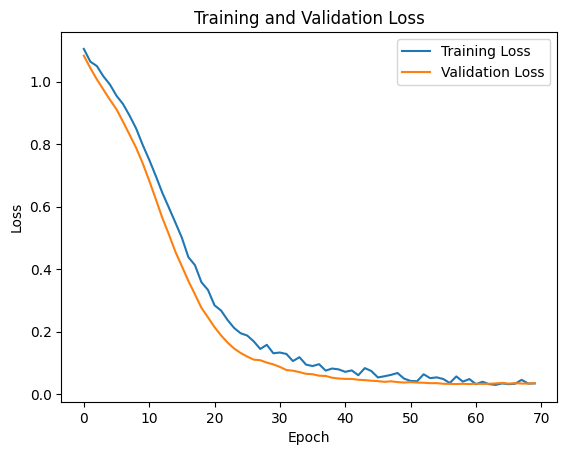

In [18]:
train(model, train_loader, val_loader, 100)

In [22]:
results = evaluate_model(model, test_loader, idx_to_class, device)
results

Accuracy: 0.9810 | F1 Score: 0.9809 | Recall Score: 0.9810 | Precision Score: 0.9817


0.9809523809523809

# Inferences

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-18.889341..16.265787].


meo-kho-2.jpg


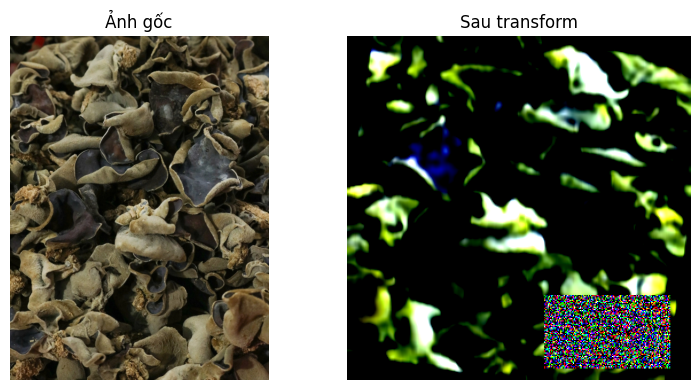

Predicted class: 1


In [20]:
folder_path = TRAIN_FOLDER_PATH +"/đông cô" 
image_files = os.listdir(folder_path)
# image_path = os.path.join(folder_path, random.choice(image_files))
image_path = "meo-kho-2.jpg"
img_original = Image.open(image_path).convert('RGB')
img_transformed = transform(img_original)
print(image_path)

def tensor_to_img(img_tensor):
    img = img_tensor.permute(1, 2, 0).numpy()
    return img

# Vẽ ảnh gốc và ảnh transform
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_original)
plt.title("Ảnh gốc")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(tensor_to_img(img_transformed))
plt.title("Sau transform")
plt.axis("off")

plt.tight_layout()
plt.show()

def predict_image(model, img_path, transform, class_names):
    image = Image.open(img_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
        
    return class_names[predicted_class]

predicted = predict_image(model, image_path, test_transform, idx_to_class)
print("Predicted class:", predicted)

# Submit

In [21]:
# PATH = "res50_9964_2e-5.pth"
# model.load_state_dict(torch.load(PATH, weights_only=True))
# model.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'res50_9964_2e-5.pth'

In [27]:
def create_submission(model, dataloader, idx_to_class, device):
    model.eval()
    results = []
    file_names = []

    with torch.no_grad():
        for inputs, filenames in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            results.extend([idx_to_class[p.item()] for p in preds])
            file_names.extend(filenames)

    df = pd.DataFrame({
        "ID": [file.split('.')[0] for file in file_names],
        "label": results
    })
    df.to_csv("submission.csv", index=False)
    print("Saved submission.csv")
    return df

submit_dir = TEST_FOLDER_PATH
submit_dataset = CustomTestDataset(submit_dir, transform=test_transform)
submit_loader = DataLoader(submit_dataset, batch_size=32, shuffle=False)
predcits = create_submission(model, submit_loader, idx_to_class, device)

AttributeError: 'list' object has no attribute 'split'